In [19]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from damped_newton import damped_newton, damped_newton_linesearch
from PMF import pmf_matrix_completion
from alternating_least_squares import als

In [7]:
# Here we select first 500 images and convert them to grayscale format
# I also added resize method, since some of the images a little bit bigger and it seems to be more convenient to use images of the same size

input_folder = "img_align_celeba"
output_folder = "celeba_grayscale"  # Folder to save grayscale images

# Create output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all images in the input folder
for filename in sorted(os.listdir(input_folder))[:500]:
    if filename.endswith(".jpg"):  # CelebA images are in JPG format
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Convert to grayscale
        grayscale_image = image.convert("L")
        grayscale_image = grayscale_image.resize((128, 128), Image.Resampling.LANCZOS)

        # Save the grayscale image
        output_path = os.path.join(output_folder, filename)
        grayscale_image.save(output_path)

        #print(f"Processed: {filename}")

#print("All images converted to grayscale!")

In [10]:
# Here we convert grayscale images to the arrays
image_folder = "celeba_grayscale"  # Folder containing grayscale images
# Parameters
image_size = (128, 128)  # Desired image size

# Load and preprocess images
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
num_images = len(image_files)
images = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)

    # Convert to NumPy array and normalize pixel values to [0, 1]
    image_array = np.array(image) / 255.0
    images.append(image_array)

    #print(f"Processed: {filename}")

# Convert list of images to a NumPy array
images = np.array(images)
#print(f"Loaded {num_images} images of shape {images[0].shape}.")

In [48]:
# Simple random masking with sparsity_level as a parameter
def mask_entries(image, sparsity_level=0.3,fill_value=0.0):
    mask = np.random.rand(*image.shape) < sparsity_level
    masked_image = image.copy()
    masked_image[mask] = fill_value
    return masked_image, mask

def mask_entries_with_noise(image, sparsity_level=0.3, noise_std=0.05):
    mask = np.random.rand(*image.shape) < sparsity_level
    masked_image = image.copy()

    # Add noise only to observed entries
    noise = np.random.normal(loc=0.0, scale=noise_std, size=image.shape)
    masked_image[~mask] += noise[~mask]

    # Clip to [0, 1] range to keep valid pixel intensities (optional, depending on your scaling)
    masked_image = np.clip(masked_image, 0.0, 1.0)

    return masked_image, mask

def calculate_mse(original, predicted, mask=True):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    return mse

def calculate_psnr(original, predicted, mask=True, max_pixel=1.0):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


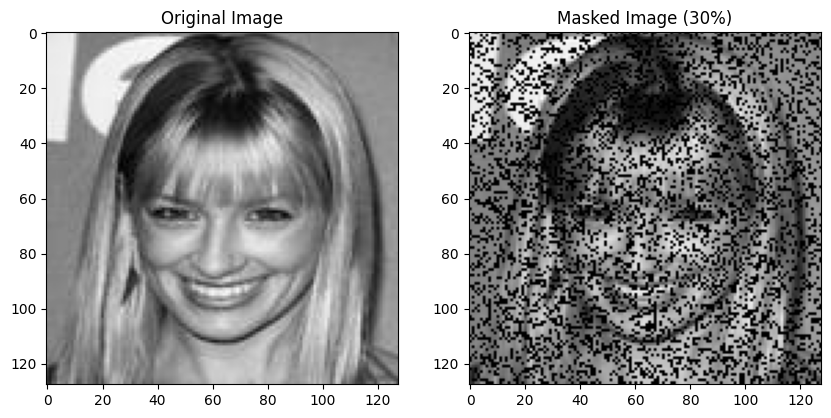

In [12]:
# Kinda scary example
masked_image, mask = mask_entries(images[2])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[2], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Masked Image (30%)")
plt.imshow(masked_image, cmap="gray")
plt.show()

In [13]:
# simple SGD example to see what results we can expect

# SGD
image_SGD = images[2]
m, n = image_SGD.shape

masked_image_SGD, mask = mask_entries(image_SGD, sparsity_level=0.3)

k = 50  # Number of latent factors
U = np.random.normal(scale=1.0/k, size=(m, k))
V = np.random.normal(scale=1.0/k, size=(n, k))
learning_rate = 0.01
regularization = 0.1
num_epochs = 300

observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

for epoch in range(num_epochs):
    np.random.shuffle(observed_pixels)  # Shuffle observed pixels
    total_error = 0
    for i, j in observed_pixels:
        error = image_SGD[i, j] - np.dot(U[i, :], V[j, :].T)
        U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])
        V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])
        total_error += error**2

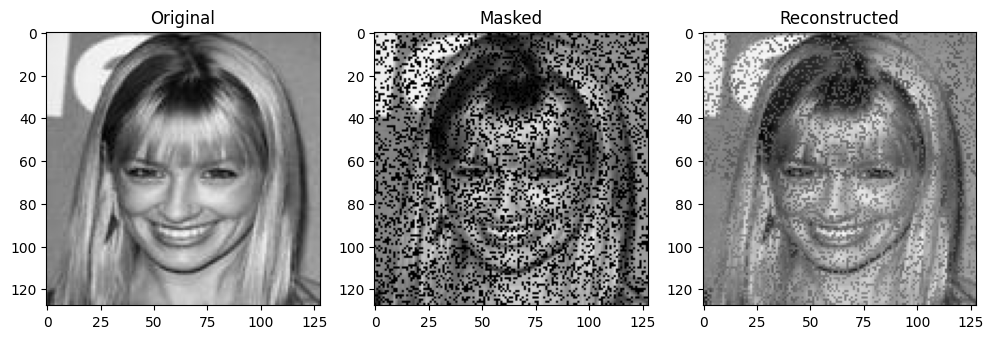

0.010561753527471993
19.76263971567068


In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_SGD, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_SGD, cmap='gray')
plt.title("Masked")

reconstructed_image_SGD = np.dot(U, V.T)
final_image = image_SGD.copy()
final_image[mask] = reconstructed_image_SGD[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title("Reconstructed (SGD)")
plt.show()
mse_SGD = calculate_mse(image_SGD,final_image,True)
psnr_SGD = calculate_psnr(image_SGD,final_image,True,max_pixel=1.0)
print(mse_SGD)
print(psnr_SGD)

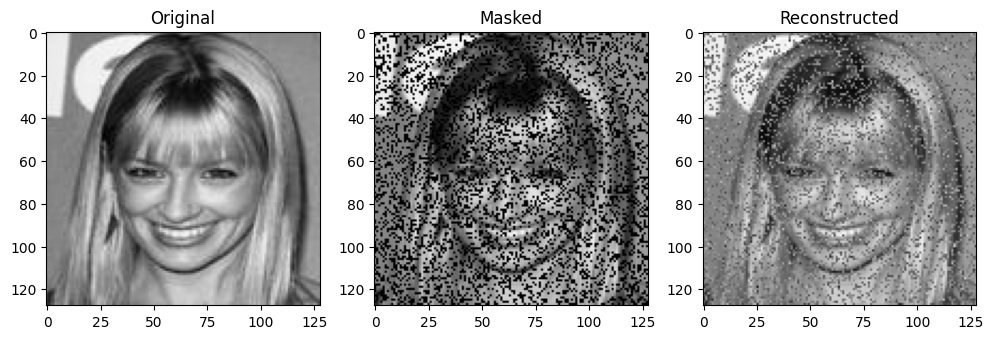

0.01476908260235419
18.306464805248275


In [15]:
image_PMF = images[2]
m, n = image_PMF.shape
masked_image_PMF, mask = mask_entries(image_PMF, sparsity_level=0.3)

U, V = pmf_matrix_completion(image_PMF, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_PMF, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_PMF, cmap='gray')
plt.title("Masked")

reconstructed_image_PMF = np.dot(U, V.T)
reconstructed_image_PMF -= reconstructed_image_PMF.min()
reconstructed_image_PMF /= reconstructed_image_PMF.max()

final_image_PMF = image_PMF.copy()
final_image_PMF[mask] = reconstructed_image_PMF[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_PMF, cmap='gray')
plt.title("Reconstructed (PMF)")
plt.show()
mse_PMF = calculate_mse(image_PMF,final_image_PMF,True)
psnr_PMF=calculate_psnr(image_PMF,final_image_PMF,True,max_pixel=1.0)
print(mse_PMF)
print(psnr_PMF)

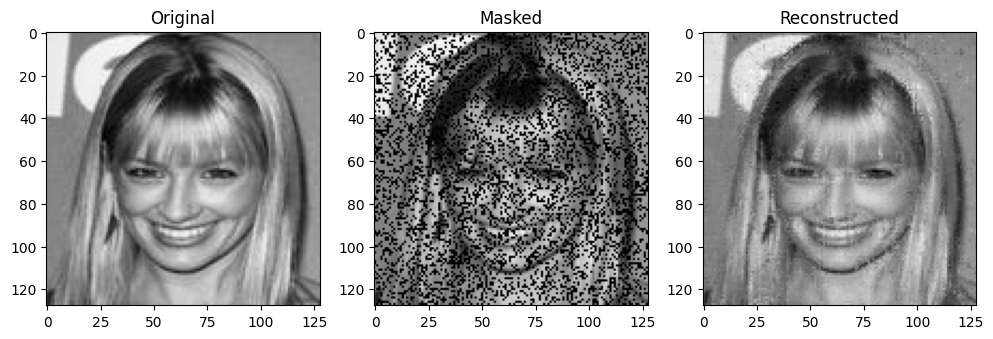

0.0018210990385428354
27.396664349172983


In [16]:
#Damped Newton
image_NT = images[2]
m, n = image_NT.shape
masked_image_NT, mask = mask_entries(image_NT, sparsity_level=0.3)
W = (masked_image_NT != 0.0).astype(float)
A,B = damped_newton(masked_image_NT,W,10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NT, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NT, cmap='gray')
plt.title("Masked")

reconstructed_image_NT = np.dot(A, B.T)
final_image_NT = image_NT.copy()
final_image_NT[mask] = reconstructed_image_NT[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NT, cmap='gray')
plt.title("Reconstructed (NT)")
plt.show()
mse_NT = calculate_mse(image_NT,final_image_NT,True)
psnr_NT=calculate_psnr(image_NT,final_image_NT,True,max_pixel=1.0)
print(mse_NT)
print(psnr_NT)


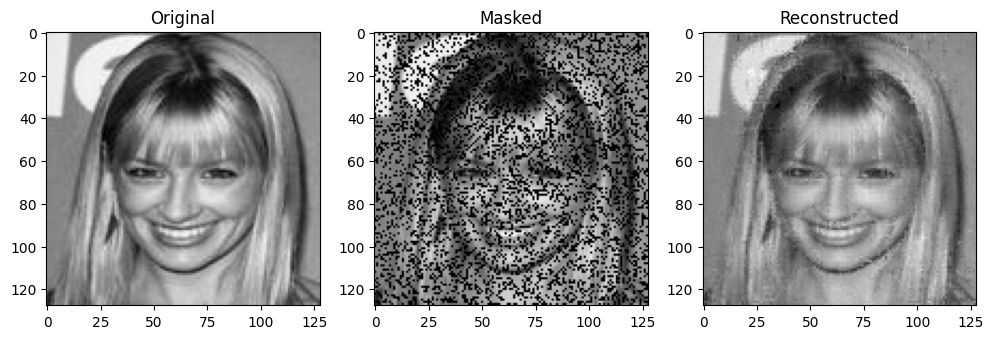

0.08608122954422465
10.650915383731041


In [17]:
#Damped Newton with linesearch
image_NTls = images[2]
m, n = image_NTls.shape
masked_image_NTls, mask = mask_entries(image_NTls, sparsity_level=0.3)
W = (masked_image_NTls != 0.0).astype(float)
A,B = damped_newton_linesearch(masked_image_NTls,W,10)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NTls, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NTls, cmap='gray')
plt.title("Masked")

reconstructed_image_NTls = np.dot(A, B.T)
final_image_NTls = image_NTls.copy()
final_image_NTls[mask] = reconstructed_image_NTls[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NTls, cmap='gray')
plt.title("Reconstructed (Damped NT)")
plt.show()
mse_NTls = calculate_mse(masked_image_NTls,final_image_NTls,True)
psnr_NTls = calculate_psnr(masked_image_NTls,final_image_NTls,True,max_pixel=1.0)
print(mse_NTls)
print(psnr_NTls)

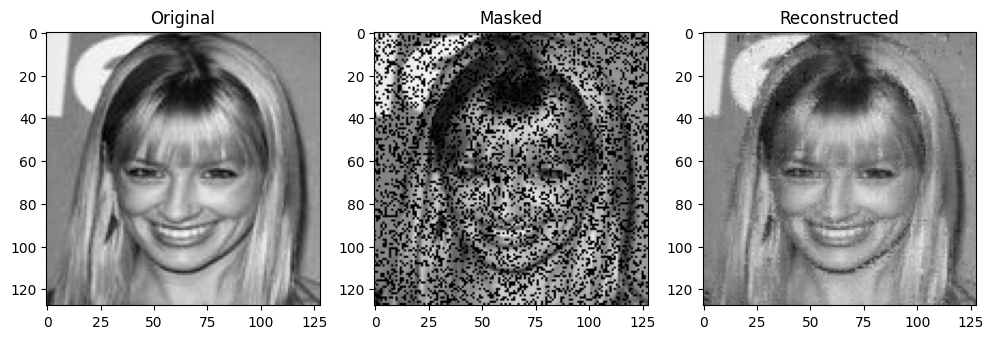

0.0016837067700101252
27.737335418477706


In [20]:
# ALS
image_ALS = images[2]
m, n = image_ALS.shape
masked_image_ALS, mask = mask_entries(image_ALS, sparsity_level=0.3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_ALS, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_ALS, cmap='gray')
plt.title("Masked")

reconstructed_image_ALS = als(masked_image_ALS, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
final_image_ALS = image_ALS.copy()
final_image_ALS[mask] = reconstructed_image_ALS[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_ALS, cmap='gray')
plt.title("Reconstructed (ALS)")
plt.show()
mse_ALS = calculate_mse(image_ALS,final_image_ALS,True)
psnr_ALS=calculate_psnr(image_ALS,final_image_ALS,True, max_pixel=1.0)
print(mse_ALS)
print(psnr_ALS)

In [21]:
# Nuclear Norm Minimization via SVT
def singular_value_thresholding(masked_image, mask, tau=0.1, delta=1.5, max_iter=200):
    m, n = masked_image.shape
    X = np.zeros((m, n))

    for iter in range(max_iter):
        # Replace observed entries with the original masked image values
        X[~mask] = masked_image[~mask]

        # SVD and soft-thresholding
        U, S, VT = np.linalg.svd(X, full_matrices=False)
        S_thresh = np.maximum(S - tau, 0)
        X = (U * S_thresh) @ VT  # reconstruct with thresholded singular values

    return X

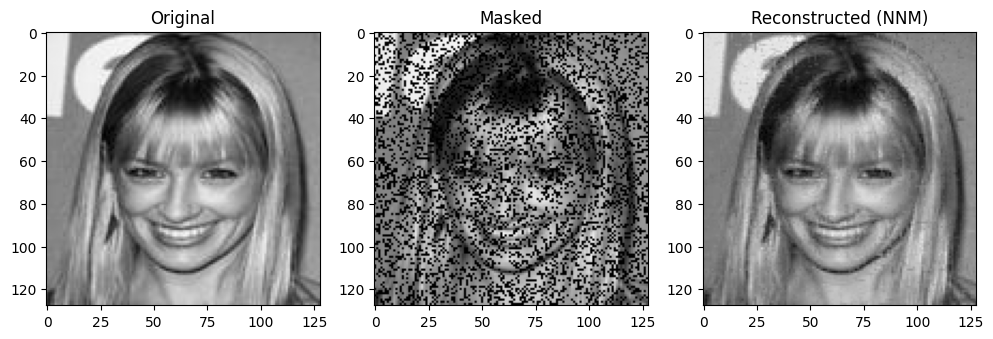

MSE: 0.0008974173017430285
PSNR: 30.47005561748464


In [23]:
image_NNM = images[2]
masked_image_NNM, mask = mask_entries(image_NNM, sparsity_level=0.3)

# Reconstruct using SVT
reconstructed_image_NNM = singular_value_thresholding(masked_image_NNM, mask, tau=0.1, delta=1.2, max_iter=200)

# Combine with known pixels
final_image_NNM = image_NNM.copy()
final_image_NNM[mask] = reconstructed_image_NNM[mask]


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NNM, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NNM, cmap='gray')
plt.title("Masked")

plt.subplot(1, 3, 3)
plt.imshow(final_image_NNM, cmap='gray')
plt.title("Reconstructed (NNM)")
plt.show()

mse_NNM = calculate_mse(image_NNM, final_image_NNM, True)
psnr_NNM = calculate_psnr(image_NNM, final_image_NNM, True, max_pixel=1.0)
print("MSE:", mse_NNM)
print("PSNR:", psnr_NNM)

## Comparison

In [24]:
sparsity_levels = np.linspace(0.1, 0.9, 9)
mse_sgd, psnr_sgd = [], []
mse_pmf, psnr_pmf = [], []
mse_ntls, psnr_ntls = [], []
mse_als, psnr_als = [], []
mse_nnm, psnr_nnm = [], []

image_index = 10  # Pick one image for consistency
image = images[image_index]
m, n = image.shape


In [25]:
for s in sparsity_levels:
    masked_image, mask = mask_entries(image, sparsity_level=s)
    U = np.random.normal(scale=1.0/k, size=(m, k))
    V = np.random.normal(scale=1.0/k, size=(n, k))

    observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

    for epoch in range(num_epochs):
        np.random.shuffle(observed_pixels)
        for i, j in observed_pixels:
            error = image[i, j] - np.dot(U[i, :], V[j, :].T)
            U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])
            V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])

    reconstructed = np.dot(U, V.T)
    reconstructed -= reconstructed.min()
    reconstructed /= reconstructed.max()

    final_image = image.copy()
    final_image[mask] = reconstructed[mask]

    mse_sgd.append(calculate_mse(image, final_image, True))
    psnr_sgd.append(calculate_psnr(image, final_image, True))



In [26]:
for s in sparsity_levels:
    # Mask the image based on the current sparsity level
    masked_image, mask = mask_entries(image, sparsity_level=s)

    # Apply PMF matrix completion
    U, V = pmf_matrix_completion(masked_image, mask)

    # Reconstruct the image
    reconstructed_image = np.dot(U, V.T)
    reconstructed_image -= reconstructed_image.min()  # Normalize to [0, 1]
    reconstructed_image /= reconstructed_image.max()

    # Create final reconstructed image with the masked pixels filled in
    final_image = image.copy()
    final_image[mask] = reconstructed_image[mask]

    # Calculate MSE and PSNR
    mse_pmf.append(calculate_mse(image, final_image, True))
    psnr_pmf.append(calculate_psnr(image, final_image, True))

In [27]:
for s in sparsity_levels:
    # Mask the image based on the current sparsity level
    masked_image, mask = mask_entries(image, sparsity_level=s)

    W = (masked_image != 0.0).astype(float)
    U, V = damped_newton_linesearch(masked_image, W, 10)

    # Reconstruct the image
    reconstructed_image = np.dot(U, V.T)
    reconstructed_image -= reconstructed_image.min()  # Normalize to [0, 1]
    reconstructed_image /= reconstructed_image.max()

    # Create final reconstructed image with the masked pixels filled in
    final_image = image.copy()
    final_image[mask] = reconstructed_image[mask]

    # Calculate MSE and PSNR
    mse_ntls.append(calculate_mse(image, final_image, True))
    psnr_ntls.append(calculate_psnr(image, final_image, True))

In [28]:
for s in sparsity_levels:
    masked_image, mask = mask_entries(image, sparsity_level=s)

    reconstructed = als(masked_image, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
    reconstructed -= reconstructed.min()
    reconstructed /= reconstructed.max()

    final_image = image.copy()
    final_image[mask] = reconstructed[mask]

    mse_als.append(calculate_mse(image, final_image, True))
    psnr_als.append(calculate_psnr(image, final_image, True))

In [29]:
for s in sparsity_levels:
    masked_image, mask = mask_entries(image, sparsity_level=s)

    reconstructed = singular_value_thresholding(masked_image, mask, tau=0.1, delta=1.2, max_iter=200)

    final_image = image.copy()
    final_image[mask] = reconstructed[mask]

    mse_nnm.append(calculate_mse(image, final_image, True))
    psnr_nnm.append(calculate_psnr(image, final_image, True))

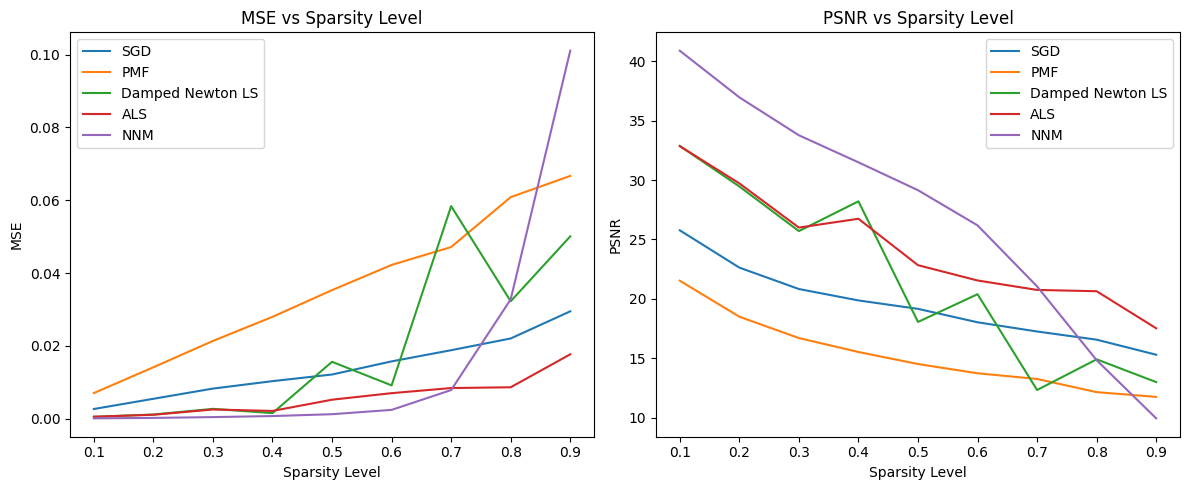

In [30]:
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(sparsity_levels, mse_sgd, label="SGD")
plt.plot(sparsity_levels, mse_pmf, label="PMF")
plt.plot(sparsity_levels, mse_ntls, label="Damped Newton LS")
plt.plot(sparsity_levels, mse_als, label="ALS")
plt.plot(sparsity_levels, mse_nnm, label="NNM")
plt.xlabel("Sparsity Level")
plt.ylabel("MSE")
plt.title("MSE vs Sparsity Level")
plt.legend()

# PSNR Plot
plt.subplot(1, 2, 2)
plt.plot(sparsity_levels, psnr_sgd, label="SGD")
plt.plot(sparsity_levels, psnr_pmf, label="PMF")
plt.plot(sparsity_levels, psnr_ntls, label="Damped Newton LS")
plt.plot(sparsity_levels, psnr_als, label="ALS")
plt.plot(sparsity_levels, psnr_nnm, label="NNM")
plt.xlabel("Sparsity Level")
plt.ylabel("PSNR")
plt.title("PSNR vs Sparsity Level")
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# num_images should be 500 but I checked only for 3 and it took like 25 minutes :c
num_images = 500
sparsity_levels = np.linspace(0.1, 0.9, 9)

# Store MSE and PSNR for each method and sparsity level
methods = ['sgd', 'pmf', 'ntls', 'als', 'nnm']
mse_results = {method: [] for method in methods}
psnr_results = {method: [] for method in methods}

In [39]:
for idx in range(num_images):
    image = images[idx]
    m, n = image.shape

    mse_sgd, psnr_sgd = [], []
    mse_pmf, psnr_pmf = [], []
    mse_ntls, psnr_ntls = [], []
    mse_als, psnr_als = [], []
    mse_nnm, psnr_nnm = [], []

    for s_idx, s in enumerate(sparsity_levels):
        masked_image, mask = mask_entries(image, sparsity_level=s)

        # --- SGD ---
        U = np.random.normal(scale=1.0/k, size=(m, k))
        V = np.random.normal(scale=1.0/k, size=(n, k))
        observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])
        for epoch in range(num_epochs):
            np.random.shuffle(observed_pixels)
            for i, j in observed_pixels:
                error = image[i, j] - np.dot(U[i], V[j])
                U[i] += learning_rate * (error * V[j] - regularization * U[i])
                V[j] += learning_rate * (error * U[i] - regularization * V[j])
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_sgd = image.copy()
        final_image_sgd[mask] = reconstructed[mask]

        mse_sgd.append(calculate_mse(image, final_image_sgd, True))
        psnr_sgd.append(calculate_psnr(image, final_image_sgd, True))

        # --- PMF ---
        U, V = pmf_matrix_completion(masked_image, mask)
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_pmf = image.copy()
        final_image_pmf[mask] = reconstructed[mask]

        mse_pmf.append(calculate_mse(image, final_image_pmf, True))
        psnr_pmf.append(calculate_psnr(image, final_image_pmf, True))

        # --- NTLS ---
        W = (masked_image != 0.0).astype(float)
        U, V = damped_newton_linesearch(masked_image, W, 10)
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_ntls = image.copy()
        final_image_ntls[mask] = reconstructed[mask]
        mse_ntls.append(calculate_mse(image, final_image_ntls, True))
        psnr_ntls.append(calculate_psnr(image, final_image_ntls, True))

        # --- ALS ---
        reconstructed = als(masked_image, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_als = image.copy()
        final_image_als[mask] = reconstructed[mask]
        mse_als.append(calculate_mse(image, final_image_als, True))
        psnr_als.append(calculate_psnr(image, final_image_als, True))

        # --- NNM ---
        reconstructed = singular_value_thresholding(masked_image, mask, tau=0.1, delta=1.2, max_iter=200)
        final_image_nnm = image.copy()
        final_image_nnm[mask] = reconstructed[mask]
        mse_nnm.append(calculate_mse(image, final_image_nnm, True))
        psnr_nnm.append(calculate_psnr(image, final_image_nnm, True))


In [40]:
    mse_results['sgd'].append(mse_sgd)
    psnr_results['sgd'].append(psnr_sgd)

    mse_results['pmf'].append(mse_pmf)
    psnr_results['pmf'].append(psnr_pmf)

    mse_results['ntls'].append(mse_ntls)
    psnr_results['ntls'].append(psnr_ntls)

    mse_results['als'].append(mse_als)
    psnr_results['als'].append(psnr_als)

    mse_results['nnm'].append(mse_nnm)
    psnr_results['nnm'].append(psnr_nnm)

In [41]:
for method in methods:
    mse_results[method] = np.array(mse_results[method])  # shape: (500, 9)
    psnr_results[method] = np.array(psnr_results[method])

mean_mse = {method: mse_results[method].mean(axis=0) for method in methods}
std_mse = {method: mse_results[method].std(axis=0) for method in methods}

mean_psnr = {method: psnr_results[method].mean(axis=0) for method in methods}
std_psnr = {method: psnr_results[method].std(axis=0) for method in methods}


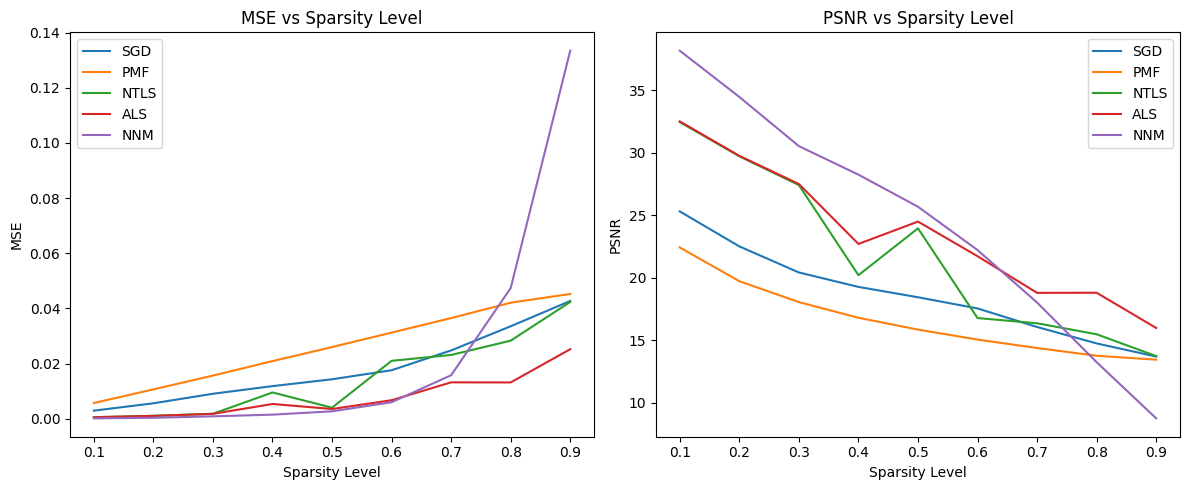

In [47]:
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
for method in methods:
    mean_vals = mean_mse[method]
    std_vals = std_mse[method]
    plt.plot(sparsity_levels, mean_vals, label=method.upper())
    plt.fill_between(sparsity_levels, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)
plt.xlabel("Sparsity Level")
plt.ylabel("MSE")
plt.title("MSE vs Sparsity Level")
plt.legend()

# PSNR Plot
plt.subplot(1, 2, 2)
for method in methods:
    mean_vals = mean_psnr[method]
    std_vals = std_psnr[method]
    plt.plot(sparsity_levels, mean_vals, label=method.upper())
    plt.fill_between(sparsity_levels, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)
plt.xlabel("Sparsity Level")
plt.ylabel("PSNR")
plt.title("PSNR vs Sparsity Level")
plt.legend()

plt.tight_layout()
plt.show()


In [52]:
# I'm not sure whether you like this idea or not but i added another mask function, where Gaussian noise was added to masked values

In [49]:
image_SGD = images[2]
m, n = image_SGD.shape

masked_image_SGD, mask = mask_entries_with_noise(image_SGD, sparsity_level=0.3, noise_std=0.05)

k = 50
U = np.random.normal(scale=1.0/k, size=(m, k))
V = np.random.normal(scale=1.0/k, size=(n, k))
learning_rate = 0.01
regularization = 0.1
num_epochs = 300

observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

for epoch in range(num_epochs):
    np.random.shuffle(observed_pixels)
    total_error = 0
    for i, j in observed_pixels:
        error = masked_image_SGD[i, j] - np.dot(U[i, :], V[j, :].T)
        U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])
        V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])
        total_error += error**2


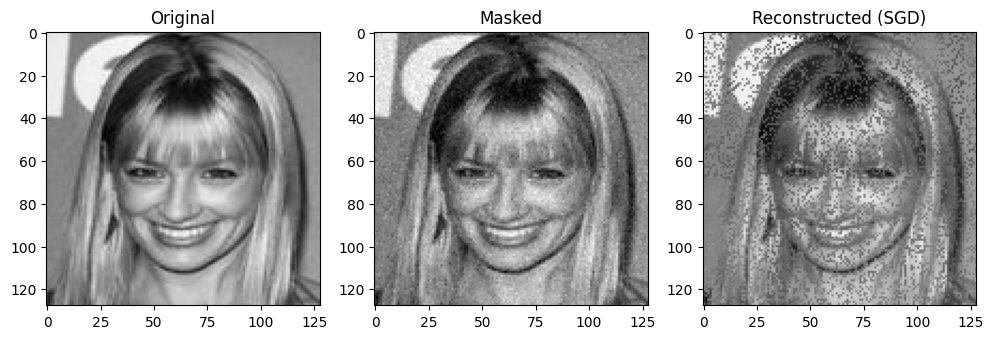

0.01064049064148416
19.730383459153714


In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_SGD, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_SGD, cmap='gray')
plt.title("Masked")

reconstructed_image_SGD = np.dot(U, V.T)
final_image = image_SGD.copy()
final_image[mask] = reconstructed_image_SGD[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title("Reconstructed (SGD)")
plt.show()
mse_SGD = calculate_mse(image_SGD,final_image,True)
psnr_SGD = calculate_psnr(image_SGD,final_image,True,max_pixel=1.0)
print(mse_SGD)
print(psnr_SGD)

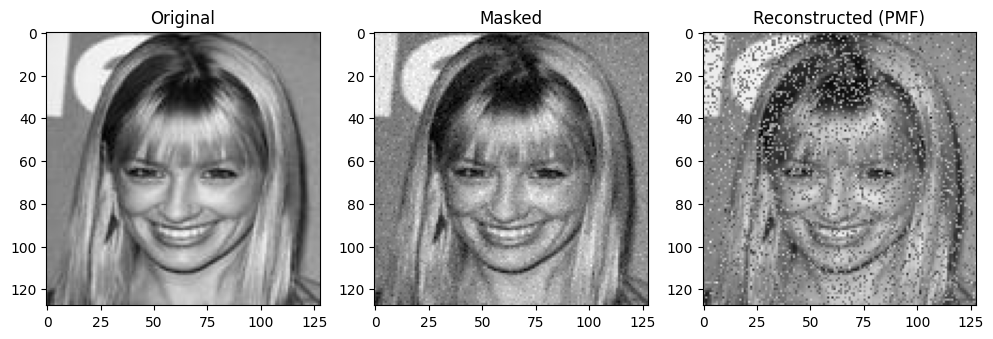

0.015148482886981595
18.196308593599703


In [51]:
image_PMF = images[2]
m, n = image_PMF.shape
masked_image_PMF, mask = mask_entries_with_noise(image_PMF, sparsity_level=0.3)

U, V = pmf_matrix_completion(image_PMF, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_PMF, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_PMF, cmap='gray')
plt.title("Masked")

reconstructed_image_PMF = np.dot(U, V.T)
reconstructed_image_PMF -= reconstructed_image_PMF.min()
reconstructed_image_PMF /= reconstructed_image_PMF.max()

final_image_PMF = image_PMF.copy()
final_image_PMF[mask] = reconstructed_image_PMF[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_PMF, cmap='gray')
plt.title("Reconstructed (PMF)")
plt.show()
mse_PMF = calculate_mse(image_PMF,final_image_PMF,True)
psnr_PMF=calculate_psnr(image_PMF,final_image_PMF,True,max_pixel=1.0)
print(mse_PMF)
print(psnr_PMF)

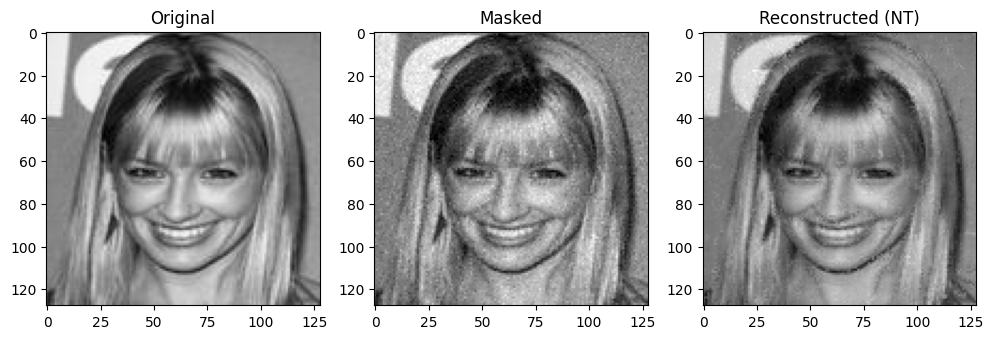

0.0012637758212612463
28.98329957876343


In [53]:
#Damped Newton
image_NT = images[2]
m, n = image_NT.shape
masked_image_NT, mask = mask_entries_with_noise(image_NT, sparsity_level=0.3)
W = (masked_image_NT != 0.0).astype(float)
A, B = damped_newton(masked_image_NT, W, 10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NT, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NT, cmap='gray')
plt.title("Masked")

reconstructed_image_NT = np.dot(A, B.T)
final_image_NT = image_NT.copy()
final_image_NT[mask] = reconstructed_image_NT[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NT, cmap='gray')
plt.title("Reconstructed (NT)")
plt.show()
mse_NT = calculate_mse(image_NT, final_image_NT, True)
psnr_NT = calculate_psnr(image_NT, final_image_NT, True, max_pixel=1.0)
print(mse_NT)
print(psnr_NT)


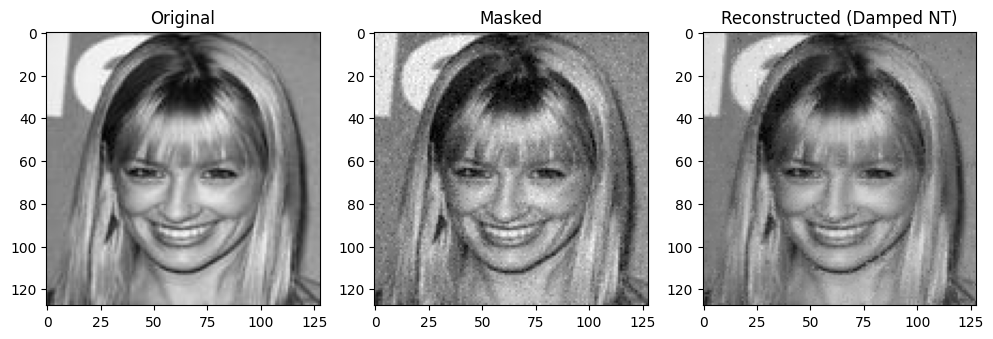

0.0028686553121685604
25.423216319618422


In [54]:
#Damped Newton with linesearch
image_NTls = images[2]
m, n = image_NTls.shape
masked_image_NTls, mask = mask_entries_with_noise(image_NTls, sparsity_level=0.3)
W = (masked_image_NTls != 0.0).astype(float)
A,B = damped_newton_linesearch(masked_image_NTls,W,10)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NTls, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NTls, cmap='gray')
plt.title("Masked")

reconstructed_image_NTls = np.dot(A, B.T)
final_image_NTls = image_NTls.copy()
final_image_NTls[mask] = reconstructed_image_NTls[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NTls, cmap='gray')
plt.title("Reconstructed (Damped NT)")
plt.show()
mse_NTls = calculate_mse(masked_image_NTls,final_image_NTls,True)
psnr_NTls = calculate_psnr(masked_image_NTls,final_image_NTls,True,max_pixel=1.0)
print(mse_NTls)
print(psnr_NTls)

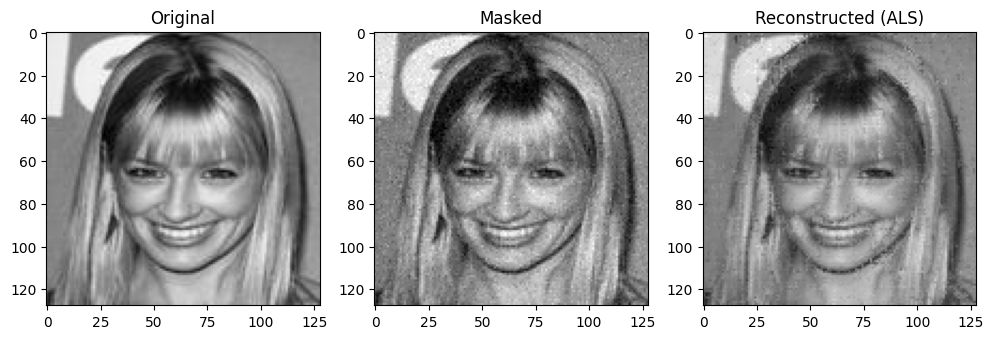

0.00191428085999717
27.179943429445096


In [55]:
# ALS
image_ALS = images[2]
m, n = image_ALS.shape
masked_image_ALS, mask = mask_entries_with_noise(image_ALS, sparsity_level=0.3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_ALS, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_ALS, cmap='gray')
plt.title("Masked")

reconstructed_image_ALS = als(masked_image_ALS, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
final_image_ALS = image_ALS.copy()
final_image_ALS[mask] = reconstructed_image_ALS[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_ALS, cmap='gray')
plt.title("Reconstructed (ALS)")
plt.show()
mse_ALS = calculate_mse(image_ALS,final_image_ALS,True)
psnr_ALS=calculate_psnr(image_ALS,final_image_ALS,True, max_pixel=1.0)
print(mse_ALS)
print(psnr_ALS)

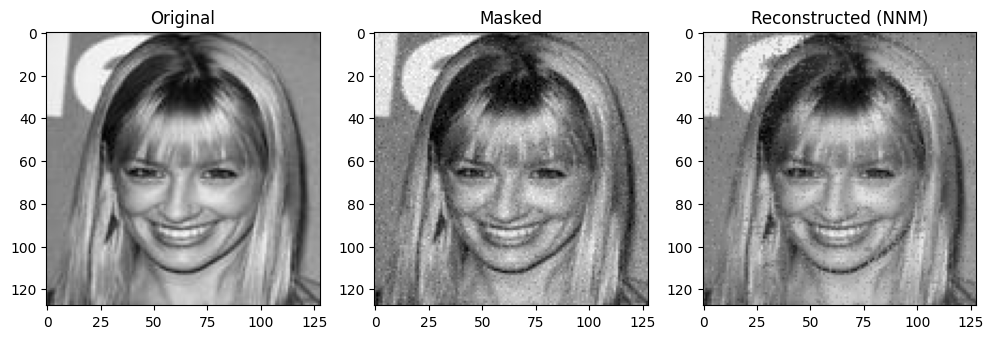

MSE: 0.0019119724124245325
PSNR: 27.185183783874457


In [56]:
image_NNM = images[2]
masked_image_NNM, mask = mask_entries_with_noise(image_NNM, sparsity_level=0.3)

# Reconstruct using SVT
reconstructed_image_NNM = singular_value_thresholding(masked_image_NNM, mask, tau=0.1, delta=1.2, max_iter=200)

# Combine with known pixels
final_image_NNM = image_NNM.copy()
final_image_NNM[mask] = reconstructed_image_NNM[mask]


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NNM, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NNM, cmap='gray')
plt.title("Masked")

plt.subplot(1, 3, 3)
plt.imshow(final_image_NNM, cmap='gray')
plt.title("Reconstructed (NNM)")
plt.show()

mse_NNM = calculate_mse(image_NNM, final_image_NNM, True)
psnr_NNM = calculate_psnr(image_NNM, final_image_NNM, True, max_pixel=1.0)
print("MSE:", mse_NNM)
print("PSNR:", psnr_NNM)

In [ ]:
num_images = 500
sparsity_levels = np.linspace(0.1, 0.9, 9)

# Store MSE and PSNR for each method and sparsity level
methods = ['sgd', 'pmf', 'ntls', 'als', 'nnm']
mse_results = {method: [] for method in methods}
psnr_results = {method: [] for method in methods}

In [ ]:
for idx in range(num_images):
    image = images[idx]
    m, n = image.shape

    mse_sgd, psnr_sgd = [], []
    mse_pmf, psnr_pmf = [], []
    mse_ntls, psnr_ntls = [], []
    mse_als, psnr_als = [], []
    mse_nnm, psnr_nnm = [], []

    for s_idx, s in enumerate(sparsity_levels):
        masked_image, mask = mask_entries_with_noise(image, sparsity_level=s)

        # --- SGD ---
        U = np.random.normal(scale=1.0/k, size=(m, k))
        V = np.random.normal(scale=1.0/k, size=(n, k))
        observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])
        for epoch in range(num_epochs):
            np.random.shuffle(observed_pixels)
            for i, j in observed_pixels:
                error = image[i, j] - np.dot(U[i], V[j])
                U[i] += learning_rate * (error * V[j] - regularization * U[i])
                V[j] += learning_rate * (error * U[i] - regularization * V[j])
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_sgd = image.copy()
        final_image_sgd[mask] = reconstructed[mask]

        mse_sgd.append(calculate_mse(image, final_image_sgd, True))
        psnr_sgd.append(calculate_psnr(image, final_image_sgd, True))

        # --- PMF ---
        U, V = pmf_matrix_completion(masked_image, mask)
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_pmf = image.copy()
        final_image_pmf[mask] = reconstructed[mask]

        mse_pmf.append(calculate_mse(image, final_image_pmf, True))
        psnr_pmf.append(calculate_psnr(image, final_image_pmf, True))

        # --- NTLS ---
        W = (masked_image != 0.0).astype(float)
        U, V = damped_newton_linesearch(masked_image, W, 10)
        reconstructed = np.dot(U, V.T)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_ntls = image.copy()
        final_image_ntls[mask] = reconstructed[mask]
        mse_ntls.append(calculate_mse(image, final_image_ntls, True))
        psnr_ntls.append(calculate_psnr(image, final_image_ntls, True))

        # --- ALS ---
        reconstructed = als(masked_image, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
        final_image_als = image.copy()
        final_image_als[mask] = reconstructed[mask]
        mse_als.append(calculate_mse(image, final_image_als, True))
        psnr_als.append(calculate_psnr(image, final_image_als, True))

        # --- NNM ---
        reconstructed = singular_value_thresholding(masked_image, mask, tau=0.1, delta=1.2, max_iter=200)
        final_image_nnm = image.copy()
        final_image_nnm[mask] = reconstructed[mask]
        mse_nnm.append(calculate_mse(image, final_image_nnm, True))
        psnr_nnm.append(calculate_psnr(image, final_image_nnm, True))

In [ ]:
    mse_results['sgd'].append(mse_sgd)
    psnr_results['sgd'].append(psnr_sgd)

    mse_results['pmf'].append(mse_pmf)
    psnr_results['pmf'].append(psnr_pmf)

    mse_results['ntls'].append(mse_ntls)
    psnr_results['ntls'].append(psnr_ntls)

    mse_results['als'].append(mse_als)
    psnr_results['als'].append(psnr_als)

    mse_results['nnm'].append(mse_nnm)
    psnr_results['nnm'].append(psnr_nnm)

In [ ]:
for method in methods:
    mse_results[method] = np.array(mse_results[method])  # shape: (500, 9)
    psnr_results[method] = np.array(psnr_results[method])

mean_mse = {method: mse_results[method].mean(axis=0) for method in methods}
std_mse = {method: mse_results[method].std(axis=0) for method in methods}

mean_psnr = {method: psnr_results[method].mean(axis=0) for method in methods}
std_psnr = {method: psnr_results[method].std(axis=0) for method in methods}


In [ ]:
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
for method in methods:
    mean_vals = mean_mse[method]
    std_vals = std_mse[method]
    plt.plot(sparsity_levels, mean_vals, label=method.upper())
    plt.fill_between(sparsity_levels, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)
plt.xlabel("Sparsity Level")
plt.ylabel("MSE")
plt.title("MSE vs Sparsity Level (with noise)")
plt.legend()

# PSNR Plot
plt.subplot(1, 2, 2)
for method in methods:
    mean_vals = mean_psnr[method]
    std_vals = std_psnr[method]
    plt.plot(sparsity_levels, mean_vals, label=method.upper())
    plt.fill_between(sparsity_levels, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)
plt.xlabel("Sparsity Level")
plt.ylabel("PSNR")
plt.title("PSNR vs Sparsity Level (with noise)")
plt.legend()

plt.tight_layout()
plt.show()